## Train classifier by layers

This notebook trains a classifier that operates in two layers:
- First we use a SVM classifier to label utterances with high degree of certainty.
- Afterwards we use heuristics to complete the labeling

### Import and path definition

In [1]:
import os
import pandas as pd
import numpy as np
import random
import pickle
import sys
import matplotlib.pyplot as plt

root_path = os.path.dirname(os.path.dirname(os.path.abspath(os.getcwd())))
sys.path.append(root_path)

from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from src import phase_classification as pc

data_path = os.path.join(root_path,'data')
tables_path = os.path.join(data_path,'tables')

### Load data

In [2]:
WITH_STEMMING = True
#REMOVE_STOPWORDS = True
SEED = 10
NUM_TOPICS = 60
random.seed(SEED)

In [3]:
file_name = '[train]IBL_topic_distribution_by_utterance_minimum_5_words_with_stemming_{}_{}.xlsx'.format(WITH_STEMMING,NUM_TOPICS)
df_data = pd.read_excel(os.path.join(tables_path,'train',file_name))

In [4]:
df_data.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,...,Topic 60,phase,phase_1,phase_2,phase_3,phase_4,phase_5,utterance,length utterance,utterance_relative_time
0,0.009546,0.012683,0.006349,0.005774,0.003684,0.005008,0.004698,0.008680,0.012694,0.015815,...,0.011693,1,1,0,0,0,0,SATUNNAINEN,0.000000,0.000000
1,0.102344,0.009047,0.004529,0.004119,0.002628,0.003573,0.003351,0.006192,0.009057,0.011282,...,0.008342,1,1,0,0,0,0,siel QUESTION_SYMBOL onks oo palo,0.065574,0.010417
2,0.102352,0.009047,0.004529,0.004119,0.002628,0.003573,0.003351,0.006192,0.009055,0.011302,...,0.008342,1,1,0,0,0,0,no tää varm muutu,0.049180,0.017361
3,0.005717,0.007596,0.003803,0.077458,0.002207,0.003000,0.002814,0.005199,0.007603,0.009472,...,0.007004,1,1,0,0,0,0,aja T_ ATOMI ehtiny törm ton ver,0.098361,0.020833
4,0.111640,0.004865,0.002435,0.002215,0.001413,0.001921,0.001802,0.003329,0.004869,0.006066,...,0.004486,1,1,0,0,0,0,ton ver ai pitä muute kato sil taas oo lask to...,0.213115,0.027778


In [5]:
the_keys = list(set(df_data['phase']))
total_samples = 0
class_samples = {}
for key in the_keys:
    n = list(df_data.phase.values).count(key)
    #print("key {}, total {}".format(key,n))
    total_samples += n
    class_samples[key] = n
print(total_samples)
for key in the_keys:
    print("key {}, samples: {}, prop: {}".format(key,class_samples[key],round(class_samples[key]*1.0/total_samples,2)))

1600
key 1, samples: 403, prop: 0.25
key 2, samples: 175, prop: 0.11
key 3, samples: 406, prop: 0.25
key 4, samples: 62, prop: 0.04
key 5, samples: 554, prop: 0.35


### split data

In [6]:
filter_rows = list(range(60))+[67,68]
row_label = 60

In [7]:
dfs_train,dfs_val = pc.split_df_discussions(df_data,.2,SEED)
X_train,y_train = pc.get_joined_data_from_df(dfs_train,filter_rows,row_label)
X_val,y_val = pc.get_joined_data_from_df(dfs_val,filter_rows,row_label)
len(X_train)

1328

In [8]:
dfs_all,_ = pc.split_df_discussions(df_data,.0,SEED)
X_all,y_all = pc.get_joined_data_from_df(dfs_all,filter_rows,row_label)

### Classify first layer

In [9]:
len(X_train[0])

62

In [10]:
class_weight = {}
for key in the_keys:
    class_weight[key] = 1000.0/class_samples[key]

In [11]:
svc = SVC(kernel='linear',random_state=SEED,max_iter=3000,probability=True,class_weight=class_weight)
svc.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svc.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svc.score(X_val, y_val)))

Accuracy of SVM classifier on training set: 0.40
Accuracy of SVM classifier on test set: 0.33


In [12]:
pred = svc.predict(X_val)
labels = ["Phase {}".format(i) for i in range(1,6)]
df = pd.DataFrame(confusion_matrix(y_val, pred),columns=["Predicted {}".format(i) for i in labels])
df.index = labels
#print(" ")
print(classification_report(y_val, pred))
df

              precision    recall  f1-score   support

           1       0.68      0.60      0.64       101
           2       0.09      0.56      0.15         9
           3       0.30      0.05      0.08        63
           4       0.04      1.00      0.08         3
           5       0.51      0.20      0.29        96

   micro avg       0.33      0.33      0.33       272
   macro avg       0.32      0.48      0.25       272
weighted avg       0.51      0.33      0.36       272



,Predicted Phase 1,Predicted Phase 2,Predicted Phase 3,Predicted Phase 4,Predicted Phase 5
Phase 1,61,20,3,10,7
Phase 2,0,5,0,3,1
Phase 3,16,15,3,19,10
Phase 4,0,0,0,3,0
Phase 5,13,18,4,42,19


### Find threshold

Look for the distance to the second max

In [13]:
pred_val = svc.predict_proba(X_val)
prob_pred = [v[int(y_val[i]-1)] for i,v in enumerate(pred_val)]

(array([16., 29., 45., 33., 24., 26., 24., 37., 28., 10.]),
 array([0.0293428 , 0.09870144, 0.16806009, 0.23741873, 0.30677738,
        0.37613602, 0.44549467, 0.51485331, 0.58421196, 0.6535706 ,
        0.72292925]),
 <a list of 10 Patch objects>)

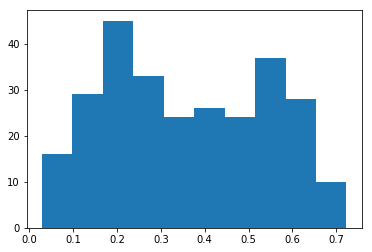

In [14]:
plt.hist(prob_pred)

In [15]:
tuple_winner_pred = [(np.max(v),prob_pred[i],np.max(v)==prob_pred[i]) for i,v in enumerate(pred_val)]
values_ok = [v[0] for i,v in enumerate(tuple_winner_pred) if v[2]==True]
values_not_ok = [v[0] for i,v in enumerate(tuple_winner_pred) if v[2]==False]
values_dist_not_ok = [v[0]-v[1] for i,v in enumerate(tuple_winner_pred) if v[2]==False]

(array([0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 1., 3., 4., 2., 9., 2., 3.,
        3., 2., 5., 5., 2., 2., 2., 5., 6., 9., 5., 2., 6., 9., 4., 5., 2.,
        4., 3., 2., 2., 3., 2., 3., 3., 4., 1., 2., 0., 0., 1., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.]),
 array([0.2 , 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 ,
        0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41,
        0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52,
        0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63,
        0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74,
        0.75, 0.76, 0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85,
        0.86, 0.87, 0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94]),
 <a list of 74 Patch objects>)

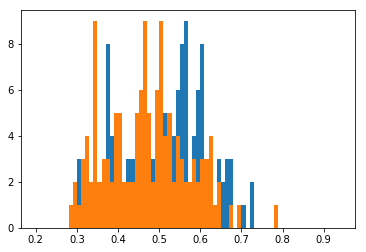

In [16]:
plt.hist(values_ok,np.arange(0.2,.95,.01))
plt.hist(values_not_ok,np.arange(0.2,.95,.01))

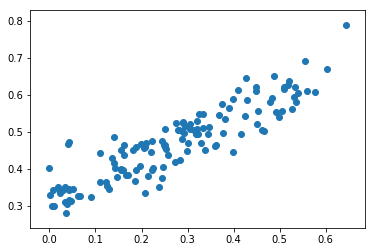

In [17]:
plt.scatter(values_dist_not_ok,values_not_ok)

Define Threshold 

In [18]:
t = 0.55

In [19]:
df_data.columns

Index(['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 'Topic 6',
       'Topic 7', 'Topic 8', 'Topic 9', 'Topic 10', 'Topic 11', 'Topic 12',
       'Topic 13', 'Topic 14', 'Topic 15', 'Topic 16', 'Topic 17', 'Topic 18',
       'Topic 19', 'Topic 20', 'Topic 21', 'Topic 22', 'Topic 23', 'Topic 24',
       'Topic 25', 'Topic 26', 'Topic 27', 'Topic 28', 'Topic 29', 'Topic 30',
       'Topic 31', 'Topic 32', 'Topic 33', 'Topic 34', 'Topic 35', 'Topic 36',
       'Topic 37', 'Topic 38', 'Topic 39', 'Topic 40', 'Topic 41', 'Topic 42',
       'Topic 43', 'Topic 44', 'Topic 45', 'Topic 46', 'Topic 47', 'Topic 48',
       'Topic 49', 'Topic 50', 'Topic 51', 'Topic 52', 'Topic 53', 'Topic 54',
       'Topic 55', 'Topic 56', 'Topic 57', 'Topic 58', 'Topic 59', 'Topic 60',
       'phase', 'phase_1', 'phase_2', 'phase_3', 'phase_4', 'phase_5',
       'utterance', 'length utterance', 'utterance_relative_time'],
      dtype='object')

In [20]:
output_first_layer = pc.first_layer_classifier(X_all,t,svc)
comparison = list(zip(output_first_layer,y_all))

In [21]:
df_data['first_layer'] = output_first_layer

### Second layer

In [22]:
second_layer,coeff = pc.second_layer_combination_before_after(X_all,df_data,svc)

In [23]:
phases = df_data.phase.values
s,v1,v2,v3 = pc.get_linear_system(X_all,svc,phases)
sol,As = pc.get_solution_linear_system(s,v1,v2,v3)

In [24]:
from scipy.optimize import minimize

In [25]:
As,bs = pc.get_elements_linear_system(s,v1,v2,v3)
fun = lambda x: np.sqrt(np.sum([np.square(np.linalg.norm(np.dot(As[i],x)-bs[i])) for i in range(len(s))])/(len(s)*2))
#fun = lambda x: np.sum([np.square(np.linalg.norm(np.dot(As[i],x)-bs[i])) for i in range(len(s))])
cons = ({'type': 'eq', 'fun': lambda x:  x[0]+x[1]+x[2]-1})
sol = minimize(fun, np.zeros(3), method='SLSQP', bounds=[(0.,1) for x in range(3)],constraints=cons)
sol.x

array([0.16893316, 0.69444097, 0.13662587])

In [26]:
sol

     fun: 0.5508051530360304
     jac: array([-0.02229001, -0.02234069, -0.02240983])
 message: 'Optimization terminated successfully.'
    nfev: 30
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([0.16893316, 0.69444097, 0.13662587])

In [27]:
fun(sol.x)

0.5508051530360304

In [28]:
fun([0,1,0])

0.5528888246644302

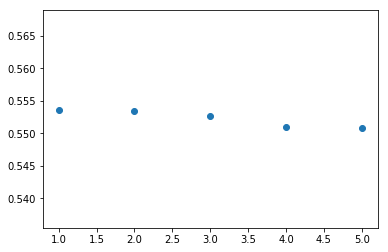

In [29]:
x = range(1,6)
y = []
for i in range(1,6):
    sol = minimize(fun, np.zeros(3), method='SLSQP', bounds=[(0.,1) for x in range(3)],constraints=cons,options={'maxiter':i})
    y.append(fun(sol.x))
plt.scatter(x,y)
#plt.ylim(0.632,.63265)

In [30]:
"Number of not predicted {}".format(second_layer.count(-1))

'Number of not predicted 0'

In [31]:
df_data['second_layer'] = second_layer

In [32]:
df = pd.DataFrame(confusion_matrix(y_all, second_layer),columns=["Predicted {}".format(i) for i in labels])
df.index = labels
print(classification_report(y_all, second_layer))
df

              precision    recall  f1-score   support

           1       0.55      0.67      0.60       403
           2       0.67      0.01      0.02       175
           3       0.70      0.37      0.48       406
           4       1.00      0.03      0.06        62
           5       0.48      0.76      0.59       554

   micro avg       0.53      0.53      0.53      1600
   macro avg       0.68      0.37      0.35      1600
weighted avg       0.59      0.53      0.48      1600



,Predicted Phase 1,Predicted Phase 2,Predicted Phase 3,Predicted Phase 4,Predicted Phase 5
Phase 1,271,1,25,0,106
Phase 2,41,2,5,0,127
Phase 3,82,0,150,0,174
Phase 4,0,0,1,2,59
Phase 5,99,0,32,0,423


In [33]:
with open(os.path.join(data_path,'classifier_svm_linear_combination_svc.pickle'),'wb') as f:
    pickle.dump(svc,f)
    pickle.dump(coeff,f)
    pickle.dump(t,f)

In [34]:
df_data.to_excel(os.path.join(tables_path,'[second_layer]'+file_name))

In [35]:
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svc.score(X_all, second_layer)))

Accuracy of SVM classifier on training set: 0.49


In [36]:
t

0.55